In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

data = data[data['pos'] == 1]

y = data['egtm']

X = data.drop(columns=[
    'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(0)

X = X.loc[:, ~X.columns.str.contains('stw')]

In [20]:
def fahrenheit_to_cels(series):
    return (series - 32) * (5.0/9.0)

In [23]:
(data['egt'] + data['egtm']).describe()

count     835.000000
mean      909.898123
std        61.656000
min       735.166000
25%       868.378500
50%       916.158000
75%       952.668000
max      1064.106000
dtype: float64

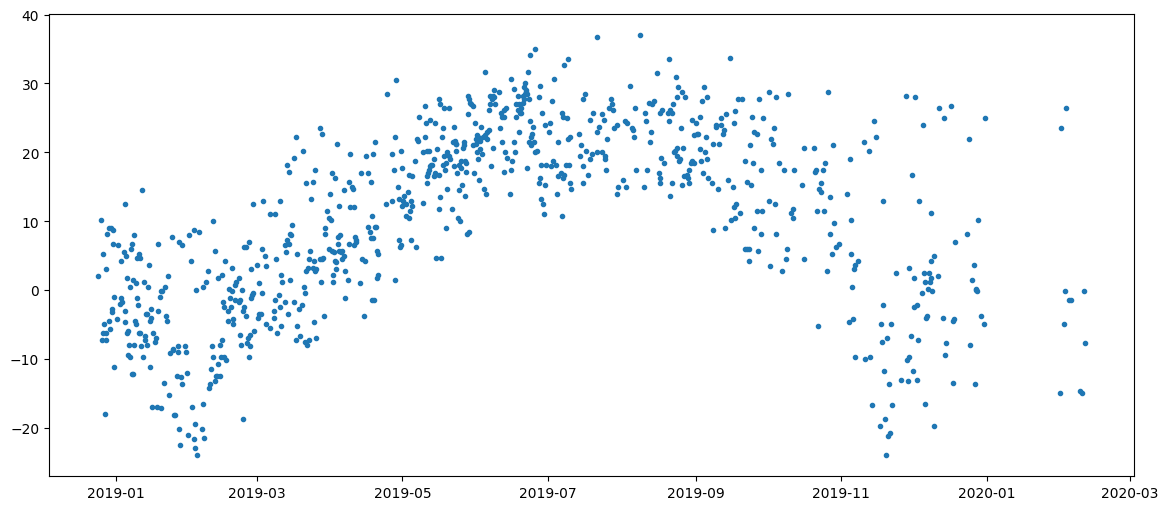

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.plot(data['reportts'], data['tat'], '.')
# ax.plot(data['reportts'], data['tatc'], '.')
plt.show()

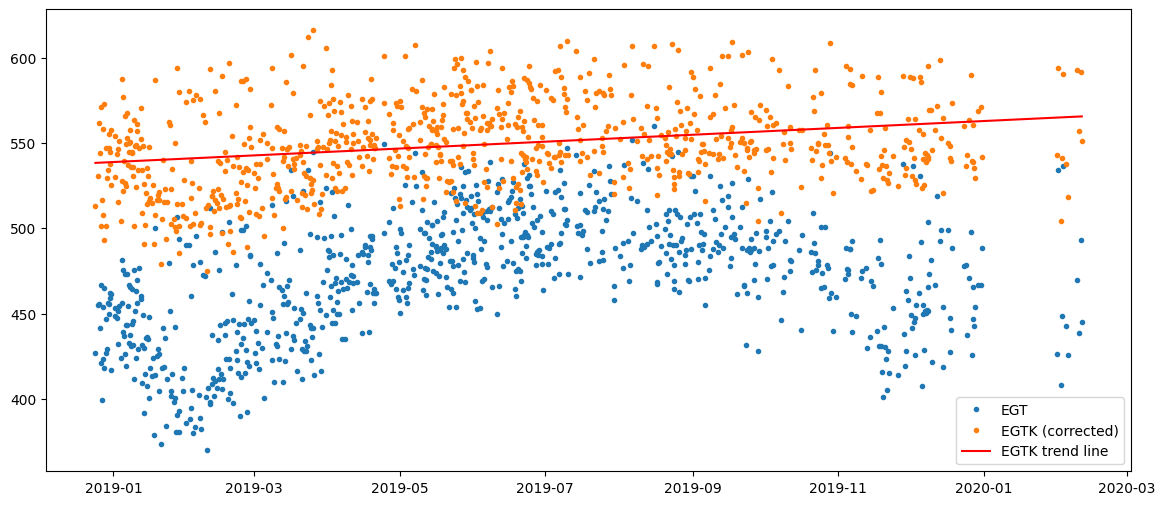

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
data['tatc'] = fahrenheit_to_cels(data['tat'])
data['theta'] = (data['tatc'] + 273.15) / 288.15

data['egtc'] = fahrenheit_to_cels(data['egt'])

data['egtk'] = (data['egtc'] + 273.15) / (data['theta']) - 273.15
z = np.polyfit(data['reportts'].astype(int) / 10**9, data['egtk'], 1)
p = np.poly1d(z)

ax.plot(data['reportts'], data['egtc'], '.')
ax.plot(data['reportts'], data['egtk'], '.')
ax.plot(data['reportts'], p(data['reportts'].astype(int) / 10**9), color='r')
ax.legend(['EGT', 'EGTK (corrected)', 'EGTK trend line'])
plt.show()

In [3]:
data['theta'].describe()

count    835.000000
mean       0.982802
std        0.045722
min        0.864654
25%        0.947250
50%        0.989589
75%        1.020822
max        1.076349
Name: theta, dtype: float64

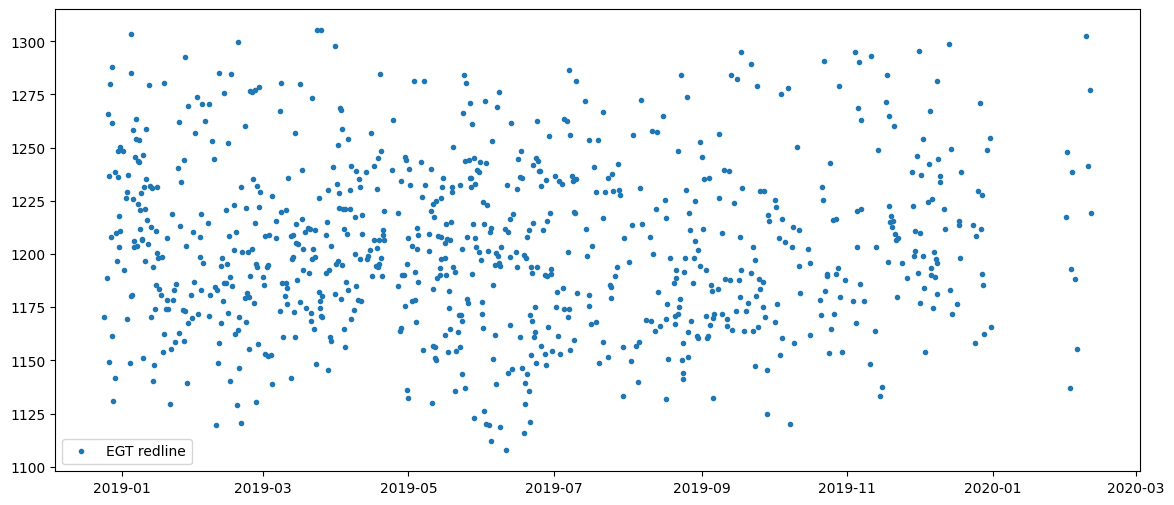

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data['egt_redline'] = (data['egtm'] / (data['theta']) + data['egtk'])

ax.plot(data['reportts'], data['egt_redline'], '.')
ax.legend(['EGT redline'])
plt.show()

In [5]:
data['egt_redline'].describe()

count     835.000000
mean     1204.051841
std        39.290052
min      1107.770407
25%      1175.146342
50%      1201.101822
75%      1231.417262
max      1305.175098
Name: egt_redline, dtype: float64

In [14]:
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [7]:
def train_model(X, y):
    # assert len(X) == len(y)
    # train_i = int(len(X) * 60 / 100)
    # X_train, y_train = X[0:train_i], y[0:train_i]
    # X_test, y_test = X[train_i:], y[train_i:]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train, y_train)

    predicted = model.predict(X_test)
    mse = mean_squared_error(y_test, predicted, squared=False)
    mae = mean_absolute_error(y_test, predicted)

    return mse, mae

In [8]:
train_model(X, data['egtk'])

(1.3006326935036174, 0.6400655874747141)

In [11]:

y = data['egt_redline']

important_features = ['naiup', 'ecyc', 'oat', 'fdp', 'ehrs', 'tec', 't2', 'egt', 'egt_peak', 'tat', 'tat_peak']

model = GradientBoostingRegressor()
preds = cross_val_predict(model, X, y)
rmse = mean_squared_error(y, preds, squared=False)
mae = mean_absolute_error(y, preds)


In [13]:
rmse, mae

(10.89062660028252, 8.150023464643166)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(14, 6))
# data['egtc'] = cels_to_fahrenheit(data['egt'])
# data['tatc'] = cels_to_fahrenheit(data['tat'])
# data['theta2'] = (data['tatc'] + 273.15) / 288.15
# data['egtk'] = (data['egtc'] + 273.15) / (data['theta2'] ** 1)
# z = np.polyfit(data['reportts'].astype(int) / 10**9, data['egtk'], 1)
# p = np.poly1d(z)
# ax.plot(data['reportts'], data['egt'], '.')
# ax.plot(data['reportts'], data['egtk'], '.')
# plt.show()